In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define MLP Classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(MLPClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        return self.fc(x)

# Train function
def train_mlp_classifier(X, y, n_epochs=100, batch_size=64):
    # Normalize and flatten
    X = X / 500.0
    X = X.reshape(X.shape[0], -1)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    # Dataset and loader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Model and optimizer
    input_dim = X.shape[1]
    n_classes = len(np.unique(y))
    model = MLPClassifier(input_dim, n_classes).to(device)

    # Class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                y_pred = torch.argmax(model(X_test_tensor), dim=1).cpu().numpy()
                y_true = y_test_tensor.cpu().numpy()
                print(f"\n🎯 Epoch {epoch + 1}/{n_epochs} | Loss: {total_loss:.4f}")
                print("🧮 Prediction distribution:", dict(Counter(y_pred)))
                print(classification_report(y_true, y_pred, target_names=[f"class {i}" for i in range(n_classes)]))

    return model, X_test_tensor, y_test_tensor


In [11]:
import json
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_with_labels(model, X_test_tensor, y_test_tensor, label_map_path="label_map_intera_2.json"):
    # Load label map
    with open(label_map_path, "r") as f:
        label_map = json.load(f)

    # Reverse mapping: {0: "intera-", 1: "non-intera"}
    index_to_class = {v: k for k, v in label_map.items()}
    class_names = [index_to_class[i] for i in range(len(index_to_class))]

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        y_pred_labels = torch.argmax(y_pred, dim=1).cpu().numpy()
        y_true = y_test_tensor.cpu().numpy()

    print("📋 Classification Report:")
    print(classification_report(y_true, y_pred_labels, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Confusion matrix (percent)
    cm = confusion_matrix(y_true, y_pred_labels)
    cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100
    cm_percent = np.round(cm_percent, 1)  # round to 1 decimal place

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (%)")
    plt.tight_layout()
    plt.show()

✅ Loaded: (6442, 75, 74) (6442,)

🎯 Epoch 10/1000 | Loss: 51.1777
🧮 Prediction distribution: {0: 1074, 1: 215}
              precision    recall  f1-score   support

     class 0       0.97      0.84      0.90      1244
     class 1       0.08      0.40      0.14        45

    accuracy                           0.83      1289
   macro avg       0.53      0.62      0.52      1289
weighted avg       0.94      0.83      0.88      1289


🎯 Epoch 20/1000 | Loss: 45.6917
🧮 Prediction distribution: {0: 1120, 1: 169}
              precision    recall  f1-score   support

     class 0       0.98      0.88      0.93      1244
     class 1       0.11      0.42      0.18        45

    accuracy                           0.86      1289
   macro avg       0.54      0.65      0.55      1289
weighted avg       0.95      0.86      0.90      1289


🎯 Epoch 30/1000 | Loss: 42.1720
🧮 Prediction distribution: {0: 1174, 1: 115}
              precision    recall  f1-score   support

     class 0       0.99 

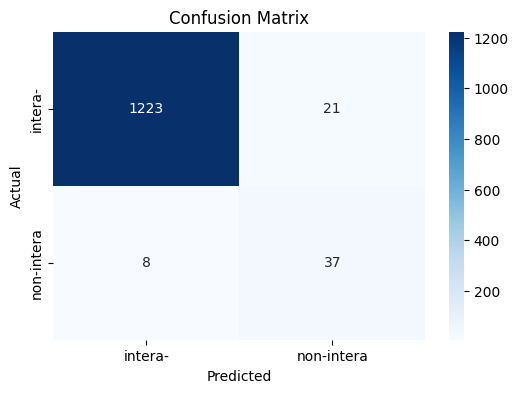

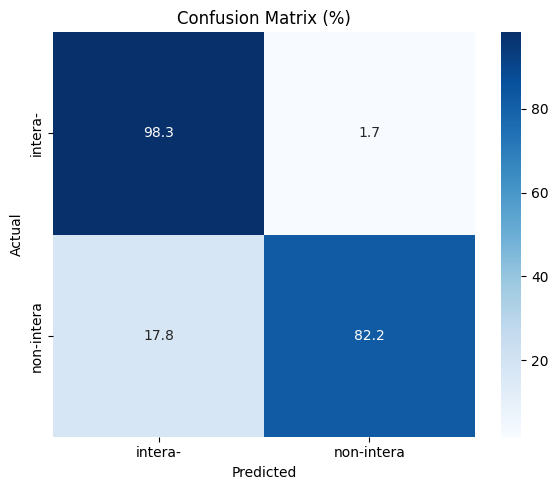

✅ Model saved to dqn_model_child_fixed.pth


In [ ]:
import numpy as np
import pandas as pd
import random
import os
import json

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Fix GPU randomness for reproducibility (optional)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

def interpolate_missing_data(data):
    """Interpolates missing numeric values and removes all remaining NaNs."""
    # Ensure numeric dtypes are inferred
    data = data.infer_objects(copy=False)

    # Preserve non-numeric columns (e.g., 'Frame')
    frame_col = data['Frame'] if 'Frame' in data.columns else None

    # Drop non-numeric columns for processing
    numeric_data = data.drop(columns=['Frame'], errors='ignore')

    # Replace 0s with NaN (assumed to be missing keypoints)
    numeric_data = numeric_data.replace(0, np.nan)

    # Interpolate first using linear interpolation over the index
    numeric_data = numeric_data.interpolate(method='linear', limit_direction='both')

    # Forward-fill and backward-fill to handle edge NaNs
    numeric_data = numeric_data.ffill().bfill()

    # Final check – force fill any residual NaNs (if any)
    numeric_data = numeric_data.fillna(0)

    # Reattach non-numeric columns, if they exist
    if frame_col is not None:
        numeric_data.insert(0, 'Frame', frame_col)

    return numeric_data

def load_data_intera(folder_path, window_size=75, step_size=37):
    """
    Loads CSV files directly from `folder_path`, interpolates missing values,
    slices the data into sliding windows, and assigns labels based on file names.
    
    Files with names containing '(Intera-)' are assigned the label 'intera-'.
    All other files are assigned the label 'non-intera'.
    """
    X, y = [], []
    
    # Define the two classes with fixed label mapping.
    label_map = {"intera-": 0, "non-intera": 1}

    # List CSV files in the given folder
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            data = pd.read_csv(file_path)
            
            # Ensure a 'Frame' column exists
            if 'Frame' not in data.columns:
                data.insert(0, "Frame", range(1, len(data) + 1))
            
            data = interpolate_missing_data(data)
            data = data.drop(columns=['Frame'], errors='ignore')

            # Determine label based on file name
            if "(Intera-)" in file:
                label = label_map["intera-"]
            else:
                label = label_map["non-intera"]

            # Generate sliding windows from the data
            for start in range(0, len(data) - window_size + 1, step_size):
                window = data[start:start + window_size]
                X.append(window)
                y.append(label)

    return np.array(X, dtype='float32'), np.array(y), label_map

# Path to your specific folder containing the files
folder_path = r"E:\Projects\CRC Projects\output_keypoints7_5_2"

X_intera, y_intera, label_map = load_data_intera(folder_path, window_size=75, step_size=37)

print("✅ Loaded:", X_intera.shape, y_intera.shape)

# Save the label mapping to a JSON file
with open("label_map_intera_2.json", "w") as f:
    json.dump(label_map, f)


# After loading your data
# X_train, X_test, y_train, y_test = train_test_split(
#     X_intera, y_intera, test_size=0.2, stratify=y_intera, random_state=42
# )

# n_classes = len(np.unique(y_intera))
# model, loss_log = train_dqn_fixed(X_train, y_train, X_test, y_test, n_actions=n_classes, num_episodes=1000)

model, X_test_tensor, y_test_tensor = train_mlp_classifier(X_intera, y_intera, n_epochs=1000)
evaluate_model_with_labels(model, X_test_tensor, y_test_tensor, label_map_path="label_map_intera_2.json")


torch.save(model.state_dict(), "dqn_model_child_fixed.pth")
print("✅ Model saved to dqn_model_child_fixed.pth")